# 0. Import libraries

The libraries used to create the data are in the following cell

In [1]:
# Project utils libraries

# From the constants library import the following constants
from constants import DATA_FOLDER_PATH

# From the plot surfaces library import the following functions
from plot_surfaces import plot_2d_polar_points, \
                          plot_2d_cartesian_points, \
                          plot_surface

# From the data generation library import the following functions
from data_generation import polar_samples_unit_circle_for_data_generation, \
                            cartesian_samples_unit_square_for_data_generation, \
                            get_random_zernike_coefficients, \
                            generate_data_for_training
                            

# 1. Define paths

This section defines constants to be used in the notebook for saving the generated data

In [2]:
# Path constants
FEATURES_FILENAME = "surfaces_2d.npy"
LABELS_FILENAME = "coefficients_2d.npy"

FEATURES_FILE_PATH = f"{DATA_FOLDER_PATH}/{FEATURES_FILENAME}"
LABELS_FILE_PATH = f"{DATA_FOLDER_PATH}/{LABELS_FILENAME}"

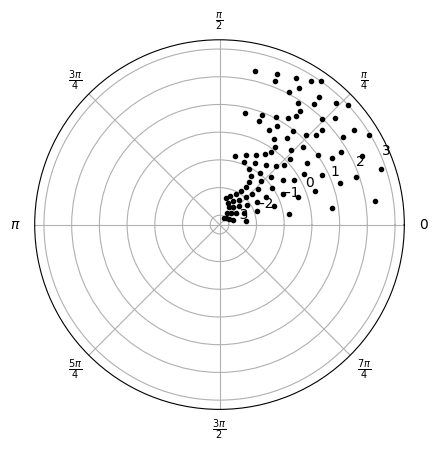

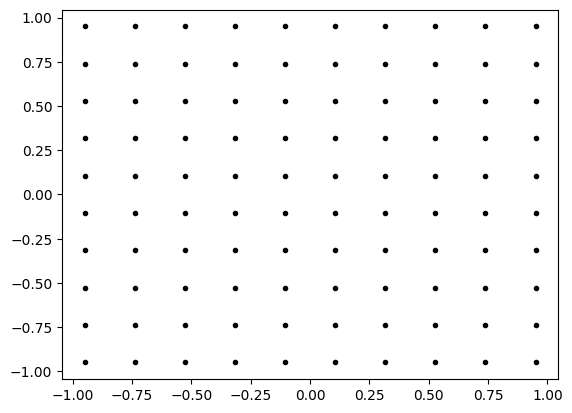

In [4]:
x_samples, y_samples = cartesian_samples_unit_square_for_data_generation()
plot_2d_cartesian_points(x_samples, y_samples)

# 2. The process of generating data

We will be generating random surfaces using the basis of the **first 19 zernike polynomials**.

In the first place we will sample points from the unit disk in polar coordinates

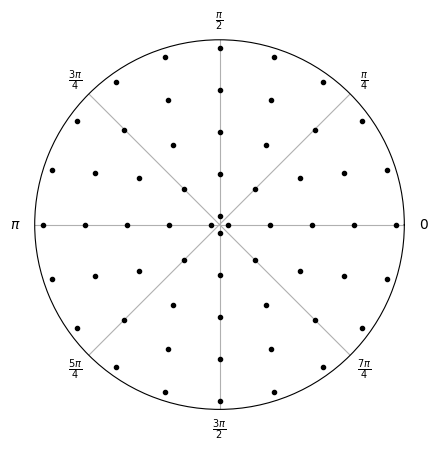

In [4]:
rho_array, varphi_array = polar_samples_unit_circle_for_data_generation()
plot_2d_polar_points(rho_array, varphi_array)

Then we will get random zernike coefficients for each polynomial that describe a random surface

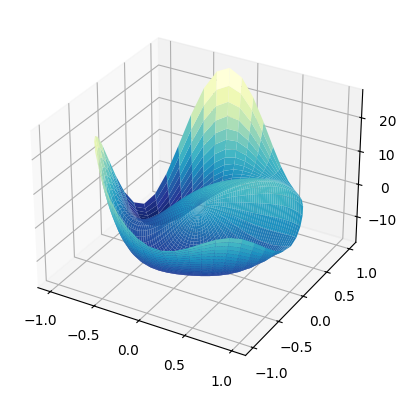

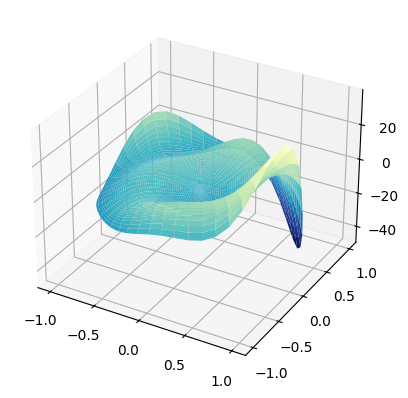

In [5]:
number_of_examples = 2
for i in range(0, number_of_examples):
    zernike_polynomials = get_random_zernike_coefficients()
    plot_surface(zernike_polynomials, verbose=True)

We will repeat this process a number of times and store the z values of the surface and its zernike coefficients in a numpy array

# 3. Data generation

We will create 60.000 data points

In [ ]:
n_surfaces = 60000
surfaces_dataframe = generate_data_for_training(n_surfaces,
                                                FEATURES_FILE_PATH,
                                                LABELS_FILE_PATH,
                                                verbose=True)